In [29]:
import pandas as pd
from sqlalchemy import create_engine
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [30]:
URI = "database-1.c5ekejexdq4k.us-east-1.rds.amazonaws.com"
PORT = "3306"
DB = "dublin_bike"
USER = "admin"
PASSWARD = "group888"

engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(USER, PASSWARD, URI, PORT, DB))

In [31]:
df_bike = pd.read_sql_table("bike_availibility", engine, parse_dates="True", index_col=0)
df_weather = pd.read_sql_table("weather", engine, parse_dates="True", index_col=0)


In [32]:
display(df_bike.head())
print(df_bike.shape)

,ID,Number,Time,Available_bike_stands,Available_bikes,Status
0,3083,42,2022-02-16 00:10:58,3,27,OPEN
1,3084,30,2022-02-16 00:10:58,17,3,OPEN
2,3085,54,2022-02-16 00:10:58,16,17,OPEN
3,3086,108,2022-02-16 00:10:58,19,16,OPEN
4,3087,56,2022-02-16 00:10:58,26,14,OPEN


(401170, 6)


In [33]:
display(df_weather.head())
print(df_weather.shape)

,ID,Time,Weather,Temp,Feels_like,Humidity
0,29,2022-02-16 00:10:58,Clear,15.07,13.44,31
1,30,2022-02-16 00:20:57,Clear,14.99,13.38,32
2,31,2022-02-16 00:31:55,Clear,14.80,13.17,32
3,32,2022-02-16 00:41:54,Clear,14.88,13.29,33
4,33,2022-02-16 00:51:26,Clear,14.64,13.02,33


(3647, 6)


In [34]:
df_combine = df_bike.merge(df_weather,left_on='Time', right_on='Time')
df_combine
# df_combine.info()

,ID_x,Number,Time,Available_bike_stands,Available_bikes,Status,ID_y,Weather,Temp,Feels_like,Humidity
0,3083,42,2022-02-16 00:10:58,3,27,OPEN,29,Clear,15.07,13.44,31
1,3084,30,2022-02-16 00:10:58,17,3,OPEN,29,Clear,15.07,13.44,31
2,3085,54,2022-02-16 00:10:58,16,17,OPEN,29,Clear,15.07,13.44,31
3,3086,108,2022-02-16 00:10:58,19,16,OPEN,29,Clear,15.07,13.44,31
4,3087,56,2022-02-16 00:10:58,26,14,OPEN,29,Clear,15.07,13.44,31
...,...,...,...,...,...,...,...,...,...,...,...
401165,404248,39,2022-04-01 13:51:35,18,2,OPEN,3675,Clear,6.92,6.92,90
401166,404249,83,2022-04-01 13:51:35,26,14,OPEN,3675,Clear,6.92,6.92,90
401167,404250,92,2022-04-01 13:51:35,25,14,OPEN,3675,Clear,6.92,6.92,90
401168,404251,21,2022-04-01 13:51:35,4,26,OPEN,3675,Clear,6.92,6.92,90


In [35]:
# Specific group
df_test_station=df_combine.groupby("Number").get_group(42)
df_test_station['Status'] = df_test_station['Status'].astype("category")
df_test_station["Weather"] = df_test_station["Weather"].astype("category")
df_test_station["Feels_like"] = df_test_station["Feels_like"].astype(float)
df_test_station = df_test_station.drop(['Number', 'ID_x', 'ID_y', 'Status'], axis=1)

/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_67071/2252232096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_station['Status'] = df_test_station['Status'].astype("category")
/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_67071/2252232096.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_station["Weather"] = df_test_station["Weather"].astype("category")
/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_67071/2252232096.py:5: SettingWithCopyWarning: 
A

In [36]:
df_test_station = df_test_station.set_index('Time')

In [37]:
df_test_station.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3647 entries, 2022-02-16 00:10:58 to 2022-04-01 13:51:35
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Available_bike_stands  3647 non-null   int64   
 1   Available_bikes        3647 non-null   int64   
 2   Weather                3647 non-null   category
 3   Temp                   3647 non-null   float64 
 4   Feels_like             3647 non-null   float64 
 5   Humidity               3647 non-null   int64   
dtypes: category(1), float64(2), int64(3)
memory usage: 174.7 KB


/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/matplotlib/axes/_base.py:506: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


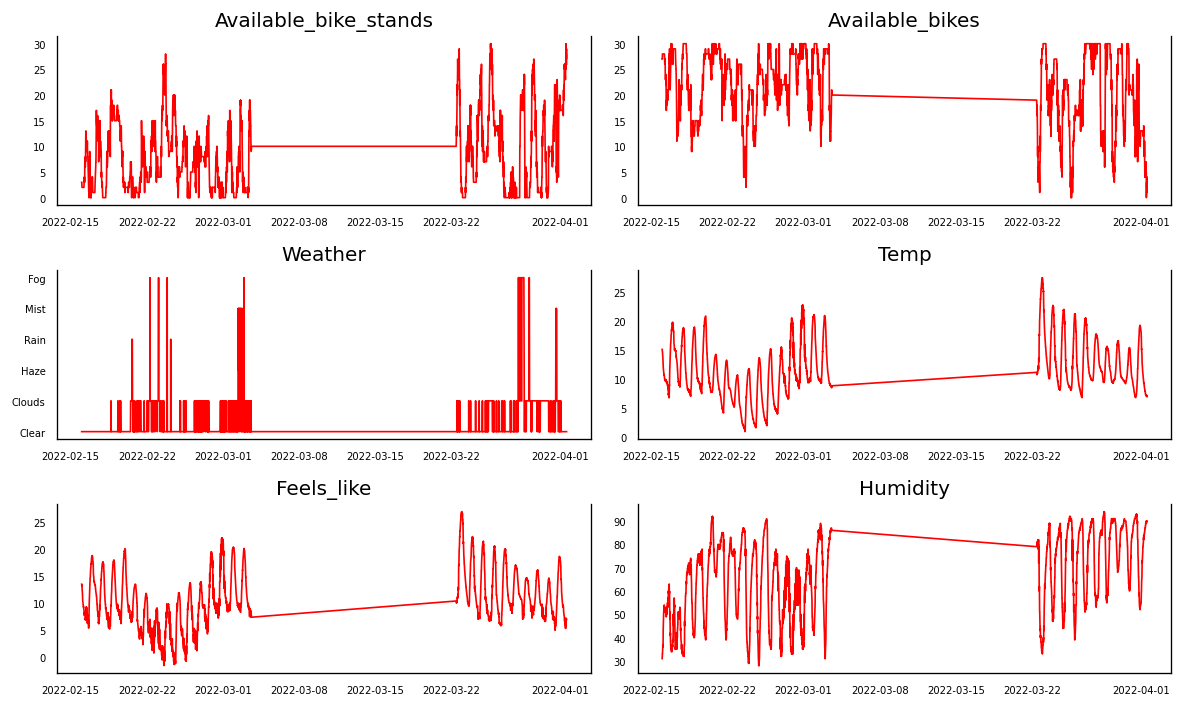

In [38]:
# Reference
# Plot 
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_test_station[df_test_station.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_test_station.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [39]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'

df_test_station = df_test_station.drop(["Weather"], axis=1)

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
grangers_causation_matrix(df_test_station, variables = df_test_station.columns) 

,Available_bike_stands_x,Available_bikes_x,Temp_x,Feels_like_x,Humidity_x
Available_bike_stands_y,1.0,0.0,0.0,0.0000,0.0
Available_bikes_y,0.0,1.0,0.0,0.0000,0.0
Temp_y,0.0,0.0,1.0,0.0004,0.0
Feels_like_y,0.0,0.0,0.0,1.0000,0.0
Humidity_y,0.0,0.0,0.0,0.0000,1.0


In [40]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_test_station)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Available_bike_stands ::  223.78    > 60.0627   =>   True
Available_bikes ::  120.52    > 40.1749   =>   True
Temp   ::  59.3      > 24.2761   =>   True
Feels_like ::  6.44      > 12.3212   =>   False
Humidity ::  0.02      > 4.1296    =>   False


In [41]:
df_test_station = df_test_station.drop(['Feels_like'], axis=1)
nobs = 12
df_train, df_test = df_test_station[0:-nobs], df_test_station[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(3635, 4)
(12, 4)


In [42]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 6), 'pvalue':round(r[1], 6), 'n_lags':round(r[2], 6), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [43]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "Available_bike_stands" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.773569
 No. Lags Chosen       = 25
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Available_bikes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.811403
 No. Lags Chosen       = 25
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Temp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

In [44]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -4.878175432521585
BIC :  -4.8440637690710835
FPE :  0.007610887998270041
HQIC:  -4.866024622299271 

Lag Order = 2
AIC :  -4.9978273657293695
BIC :  -4.936412197780026
FPE :  0.00675260228163361
HQIC:  -4.975950552438642 

Lag Order = 3
AIC :  -5.051802334662947
BIC :  -4.9630710531471145
FPE :  0.006397792868579276
HQIC:  -5.020194754438733 

Lag Order = 4
AIC :  -5.0646203511925
BIC :  -4.948560337627042
FPE :  0.006316310155274194
HQIC:  -5.023277236508121 

Lag Order = 5
AIC :  -5.125434190091716
BIC :  -4.98203281656837
FPE :  0.005943639197019507
HQIC:  -5.074350769755067 

Lag Order = 6
AIC :  -5.17660131940534
BIC :  -5.005845948581062
FPE :  0.005647171675548666
HQIC:  -5.1157728185550635 

Lag Order = 7
AIC :  -5.266355944442912
BIC :  -5.068233929530216
FPE :  0.005162395399793033
HQIC:  -5.195777584544571 

Lag Order = 8
AIC :  -5.353303233543375
BIC :  -5.127801918300656
FPE :  0.004732502129241739
HQIC:  -5.272970232385616 

Lag Order = 9
AIC :  -5.3

/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [45]:
model = VAR(df_train)
result = model.fit(4)
result.summary()

/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Apr, 2022
Time:                     15:06:06
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -4.94856
Nobs:                     3631.00    HQIC:                  -5.02328
Log likelihood:          -11345.8    FPE:                 0.00631631
AIC:                     -5.06462    Det(Omega_mle):      0.00619939
--------------------------------------------------------------------
Results for equation Available_bike_stands
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            9.046511         1.953814            4.630           0.000
L1.Available_bike_stands         0.786002         0.183494            4.284           0.000


In [46]:
from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): return str(val).ljust(length)

out = durbin_watson(result.resid)

for col, val in zip(df_test_station.columns, out):
    print(adjust(col), ':', round(val, 2))
    

Available_bike_stands : 2.0
Available_bikes : 2.0
Temp   : 2.07
Humidity : 2.04


In [47]:
lagged_Values = df_train.values[-12:]
pred = result.forecast(y=lagged_Values, steps=12) 

df_forecast=pd.DataFrame(data=pred, index=df_test_station.index[-nobs:], columns=df_test_station.columns + '_predict')
df_forecast

,Available_bike_stands_predict,Available_bikes_predict,Temp_predict,Humidity_predict
Time,,,,
2022-04-01 12:01:48,25.802262,4.190434,7.113487,88.864812
2022-04-01 12:11:10,25.575561,4.413515,7.174450,88.699976
2022-04-01 12:21:17,25.331020,4.659262,7.269122,88.335261
2022-04-01 12:31:38,25.086723,4.906956,7.404218,87.828460
2022-04-01 12:41:24,24.840235,5.157121,7.541057,87.328627
2022-04-01 12:50:57,24.591073,5.409827,7.686630,86.790681
2022-04-01 13:02:16,24.339562,5.664631,7.836293,86.240844
2022-04-01 13:10:32,24.087590,5.919628,7.985917,85.692339
2022-04-01 13:21:36,23.835196,6.174771,8.135658,85.143602


In [48]:
df_test

,Available_bike_stands,Available_bikes,Temp,Humidity
Time,,,,
2022-04-01 12:01:48,25,5,7.16,90
2022-04-01 12:11:10,30,0,7.16,90
2022-04-01 12:21:17,30,0,7.14,89
2022-04-01 12:31:38,29,1,7.09,90
2022-04-01 12:41:24,28,2,7.10,90
2022-04-01 12:50:57,28,2,7.06,90
2022-04-01 13:02:16,27,3,7.13,90
2022-04-01 13:10:32,28,2,7.00,90
2022-04-01 13:21:36,27,3,6.99,90


<AxesSubplot:xlabel='Time'>

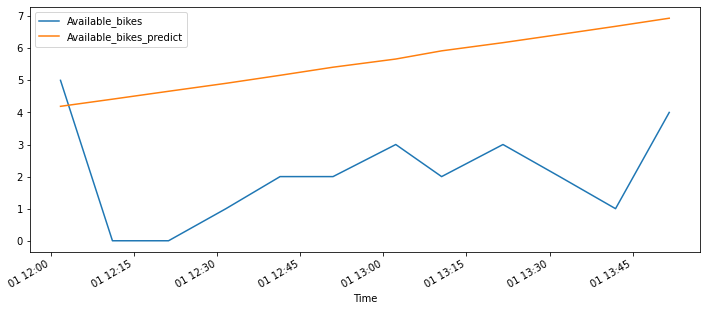

In [49]:
# Available bike predict
df_test["Available_bikes"].plot(figsize=(12,5),legend=True)
df_forecast['Available_bikes_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

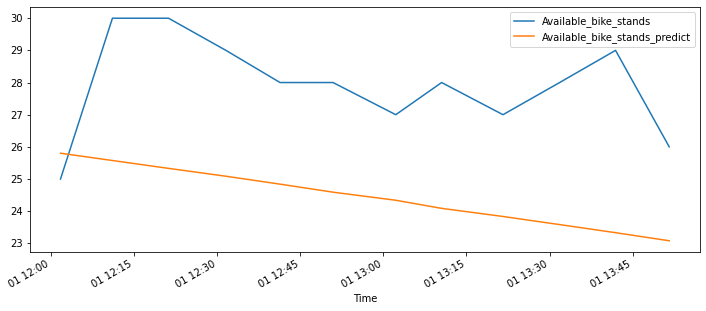

In [50]:
# Available bike stands
df_test["Available_bike_stands"].plot(figsize=(12,5),legend=True)
df_forecast['Available_bike_stands_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

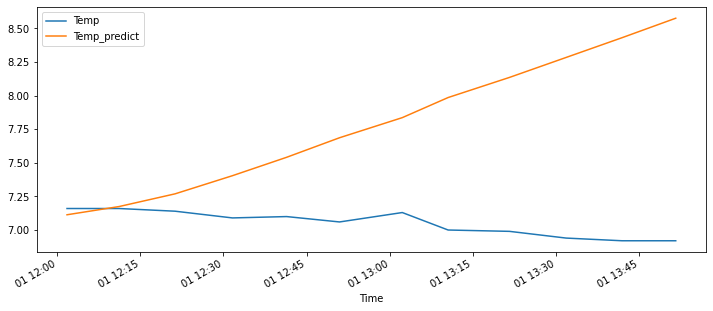

In [51]:
# Temp
df_test["Temp"].plot(figsize=(12,5),legend=True)
df_forecast['Temp_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

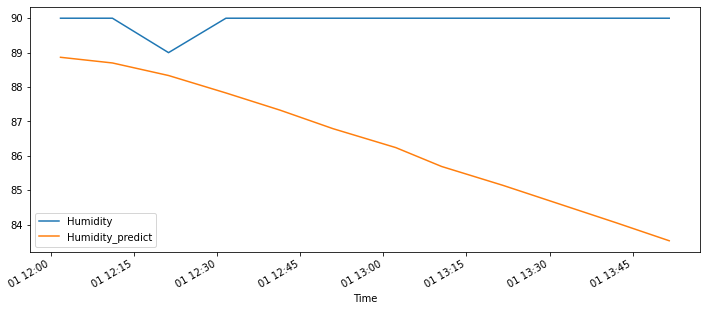

In [52]:
# Humidity
df_test["Humidity"].plot(figsize=(12,5),legend=True)
df_forecast['Humidity_predict'].plot(legend=True)

In [53]:
def rmse (forecast, actual):
    return np.mean(((forecast - actual)**2)**0.5)

# Rmse Available bikes
print("RMSE for available bikes: ", rmse(df_forecast['Available_bikes_predict'], df_test["Available_bikes"]))
# RMSE for available bike stands
print("RMSE for available bikes stands: ", rmse(df_forecast['Available_bike_stands_predict'], df_test["Available_bike_stands"]))
# RMSE for Temp
print("RMSE for Temp: ", rmse(df_forecast['Temp_predict'], df_test["Temp"]))
# RMSE for Humidity
print("RMSE for Humidity: ", rmse(df_forecast['Humidity_predict'], df_test["Humidity"]))

RMSE for available bikes:  3.597087305950598
RMSE for available bikes stands:  3.5934372232697185
RMSE for Temp:  0.7434575771523652
RMSE for Humidity:  3.4898312471606636
